<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_ayam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fae5d4fe460>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.daging_ayam_ras_segar.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


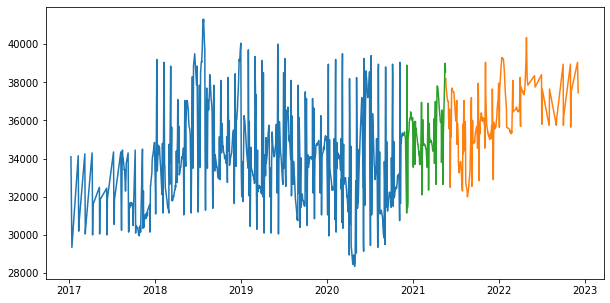

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_dagingayam_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [11]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 17s 45ms/step - loss: 0.1650 - mae: 0.3508 - mape: 254238.1406 - val_loss: 0.3318 - val_mae: 0.5415 - val_mape: 85.4220
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1130 - mae: 0.2766 - mape: 648649.6250 - val_loss: 0.2503 - val_mae: 0.4601 - val_mape: 70.2010
Epoch 3/30
44/44 [==============================] - 1s 18ms/step - loss: 0.0813 - mae: 0.2261 - mape: 702742.2500 - val_loss: 0.1981 - val_mae: 0.4026 - val_mape: 60.4851
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0637 - mae: 0.1940 - mape: 1070064.6250 - val_loss: 0.1661 - val_mae: 0.3649 - val_mape: 54.9663
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0542 - mae: 0.1767 - mape: 1197255.5000 - val_loss: 0.1432 - val_mae: 0.3350 - val_mape: 50.5927
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0489 - mae: 0.1656 - mape: 1323113.1250 - val_loss: 0.1272 - val_ma

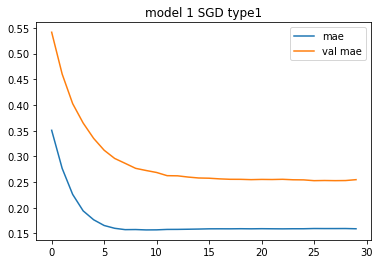

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
2683.9893 7.293607 3039.094272970156


,date,actual,prediction
0,2021-05-20,38200,33285.773438
1,2021-05-21,37850,33293.937500
2,2021-05-24,37400,33308.582031
3,2021-05-25,37300,33325.035156
4,2021-05-27,37150,33340.410156
...,...,...,...
229,2022-11-02,35650,33552.722656
230,2022-11-03,36250,33558.617188
231,2022-11-04,37500,33556.937500
232,2022-12-01,39050,33554.113281


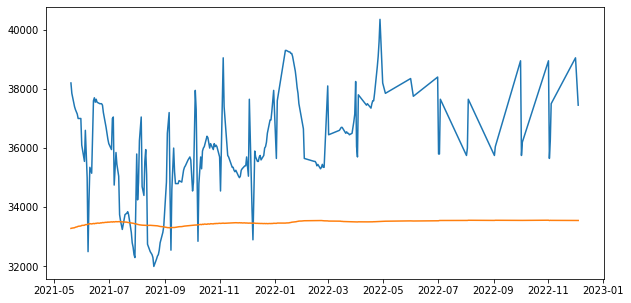

In [15]:
prediction = forecast_predict(model, test_dagingayam_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_dagingayam = pd.DataFrame()
data_new_dagingayam['date'] = y_test
data_new_dagingayam['actual'] = x_test
data_new_dagingayam['prediction'] = data_result
data_new_dagingayam.to_csv('dagingayam_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_dagingayam.date, data_new_dagingayam.actual)
plt.plot(data_new_dagingayam.date, data_new_dagingayam.prediction)
data_new_dagingayam

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0334 - mae: 0.1413 - mape: 573226.9375 - val_loss: 0.0802 - val_mae: 0.2372 - val_mape: 37.6197
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0328 - mae: 0.1410 - mape: 563391.5625 - val_loss: 0.0779 - val_mae: 0.2328 - val_mape: 37.0762
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0327 - mae: 0.1413 - mape: 534911.0000 - val_loss: 0.0761 - val_mae: 0.2293 - val_mape: 36.6344
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0326 - mae: 0.1402 - mape: 544147.9375 - val_loss: 0.0740 - val_mae: 0.2251 - val_mape: 36.1434
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0324 - mae: 0.1408 - mape: 531945.6875 - val_loss: 0.0761 - val_mae: 0.2292 - val_mape: 36.6295
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0324 - mae: 0.1400 - mape: 510720.8125 - val_loss: 0.0779 - val_

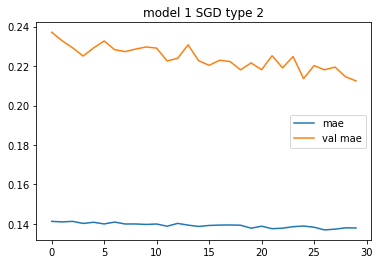

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1999.6274 5.4425907 2321.974806064872


,date,actual,prediction
0,2021-05-20,38200,33285.773438
1,2021-05-21,37850,33293.937500
2,2021-05-24,37400,33308.582031
3,2021-05-25,37300,33325.035156
4,2021-05-27,37150,33340.410156
...,...,...,...
229,2022-11-02,35650,33552.722656
230,2022-11-03,36250,33558.617188
231,2022-11-04,37500,33556.937500
232,2022-12-01,39050,33554.113281


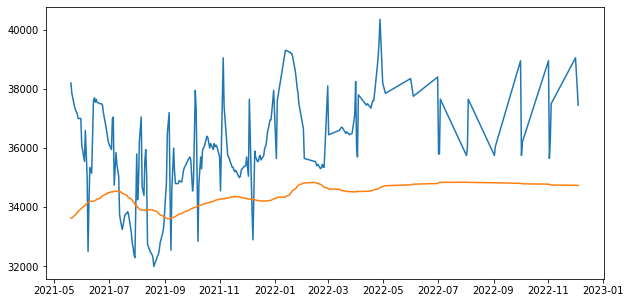

In [18]:
win_size1 = 60
test_dagingayam_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_dagingayam_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_dagingayam_1 = pd.DataFrame()
data_new_dagingayam_1['actual'] = x_test
data_new_dagingayam_1['prediction'] = data_result_1
data_new_dagingayam_1.to_csv('dagingayam_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_dagingayam_1.actual)
plt.plot(y_test, data_new_dagingayam_1.prediction)
data_new_dagingayam

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0305 - mae: 0.1344 - mape: 842387.7500 - val_loss: 0.0679 - val_mae: 0.2131 - val_mape: 34.8320
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0306 - mae: 0.1343 - mape: 835657.5625 - val_loss: 0.0678 - val_mae: 0.2130 - val_mape: 34.8209
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0306 - mae: 0.1345 - mape: 849710.5625 - val_loss: 0.0682 - val_mae: 0.2136 - val_mape: 34.8801
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0306 - mae: 0.1344 - mape: 850869.3125 - val_loss: 0.0683 - val_mae: 0.2138 - val_mape: 34.9023
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0305 - mae: 0.1342 - mape: 840103.5625 - val_loss: 0.0685 - val_mae: 0.2141 - val_mape: 34.9340
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0305 - mae: 0.1343 - mape: 841051.5625 - val_loss: 0.0680 - val_mae: 0

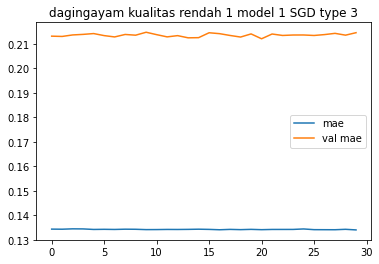

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('dagingayam kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2033.3561 5.533352 2355.3437116480472


,actual,prediction
0,38200,33598.515625
1,37850,33599.925781
2,37400,33686.726562
3,37300,33712.414062
4,37150,33797.964844
...,...,...
229,35650,34715.156250
230,36250,34714.687500
231,37500,34696.945312
232,39050,34690.347656


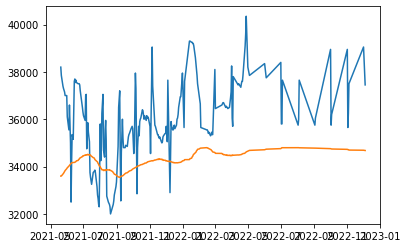

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_dagingayam_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_dagingayam_2 = pd.DataFrame()
# data_new_dagingayam1['date'] = date_test
data_new_dagingayam_2['actual'] = x_test
data_new_dagingayam_2['prediction'] = data_result_2
data_new_dagingayam_2.to_csv('dagingayam_model1_sgd_type3')

plt.plot(y_test, data_new_dagingayam_2.actual)
plt.plot(y_test, data_new_dagingayam_2.prediction)
data_new_dagingayam_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 38ms/step - loss: 0.1207 - mae: 0.2875 - mape: 446605.0312 - val_loss: 0.2050 - val_mae: 0.4099 - val_mape: 61.5869
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0614 - mae: 0.1874 - mape: 714663.3125 - val_loss: 0.0862 - val_mae: 0.2474 - val_mape: 38.9547
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0422 - mae: 0.1598 - mape: 1196115.1250 - val_loss: 0.0630 - val_mae: 0.2018 - val_mape: 33.5624
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0416 - mae: 0.1577 - mape: 1288015.0000 - val_loss: 0.0630 - val_mae: 0.2017 - val_mape: 33.5431
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0417 - mae: 0.1596 - mape: 1347600.5000 - val_loss: 0.0637 - val_mae: 0.2032 - val_mape: 33.6993
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0413 - mae: 0.1583 - mape: 1340063.1250 - val_loss: 0.0646 - val_ma

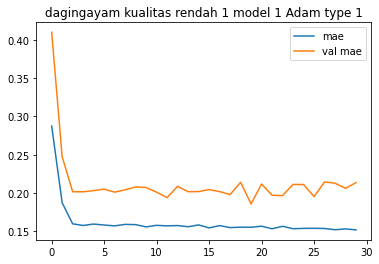

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('dagingayam kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2152.013 5.8477497 2487.251394612133


,actual,prediction
0,38200,33681.699219
1,37850,33797.945312
2,37400,33869.566406
3,37300,34049.781250
4,37150,34118.398438
...,...,...
229,35650,34245.964844
230,36250,34278.312500
231,37500,34231.070312
232,39050,34195.867188


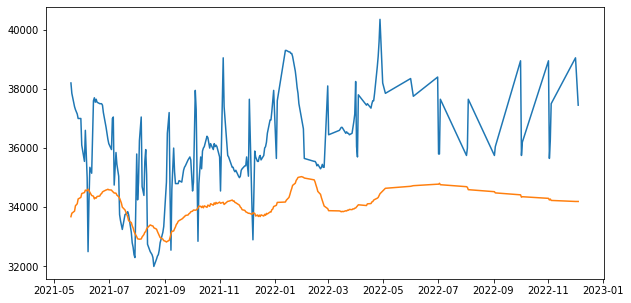

In [25]:
prediction_a = forecast_predict(model_a, test_dagingayam_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_dagingayam_a = pd.DataFrame()
# data_new_dagingayam1['date'] = date_test
data_new_dagingayam_a['actual'] = x_test
data_new_dagingayam_a['prediction'] = data_result_a
data_new_dagingayam_a.to_csv('dagingayam_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_dagingayam_a.actual)
plt.plot(y_test, data_new_dagingayam_a.prediction)
data_new_dagingayam_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0304 - mae: 0.1356 - mape: 408116.7812 - val_loss: 0.0602 - val_mae: 0.1931 - val_mape: 32.4346
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0294 - mae: 0.1330 - mape: 380052.2188 - val_loss: 0.0685 - val_mae: 0.2114 - val_mape: 34.4492
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0294 - mae: 0.1335 - mape: 366317.5938 - val_loss: 0.0690 - val_mae: 0.2120 - val_mape: 34.5098
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0295 - mae: 0.1330 - mape: 355747.2188 - val_loss: 0.0641 - val_mae: 0.2006 - val_mape: 33.1738
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0296 - mae: 0.1336 - mape: 359395.2500 - val_loss: 0.0625 - val_mae: 0.1965 - val_mape: 32.6989
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0293 - mae: 0.1328 - mape: 351721.3750 - val_loss: 0.0520 - val_

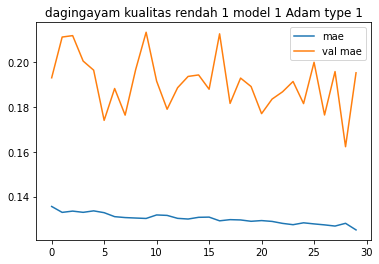

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('dagingayam kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
2204.381 5.9888573 2561.3450568012113


,actual,prediction
0,38200,33375.707031
1,37850,33353.648438
2,37400,33750.546875
3,37300,33837.082031
4,37150,34094.484375
...,...,...
229,35650,34674.312500
230,36250,34797.742188
231,37500,34609.703125
232,39050,34598.121094


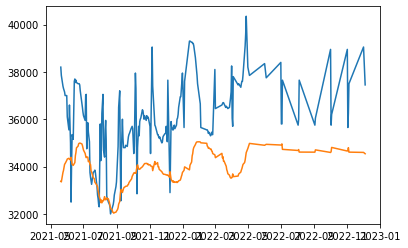

In [28]:
prediction_a1 = forecast_predict(model_a, test_dagingayam_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_dagingayam_a1 = pd.DataFrame()
data_new_dagingayam_a1['actual'] = x_test
data_new_dagingayam_a1['prediction'] = data_result_a1
data_new_dagingayam_a1.to_csv('dagingayam_model1_adam_type2.csv')

plt.plot(y_test, data_new_dagingayam_a1.actual)
plt.plot(y_test, data_new_dagingayam_a1.prediction)
data_new_dagingayam_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0270 - mae: 0.1218 - mape: 509163.6875 - val_loss: 0.0483 - val_mae: 0.1705 - val_mape: 30.6219
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0271 - mae: 0.1238 - mape: 559947.0000 - val_loss: 0.0498 - val_mae: 0.1738 - val_mape: 30.8065
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0270 - mae: 0.1223 - mape: 532140.5625 - val_loss: 0.0493 - val_mae: 0.1729 - val_mape: 30.7628
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0269 - mae: 0.1229 - mape: 558901.3750 - val_loss: 0.0504 - val_mae: 0.1754 - val_mape: 30.9333
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0270 - mae: 0.1231 - mape: 564944.7500 - val_loss: 0.0539 - val_mae: 0.1832 - val_mape: 31.5799
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0270 - mae: 0.1220 - mape: 513515.2500 - val_loss: 0.0515 - val_mae: 0

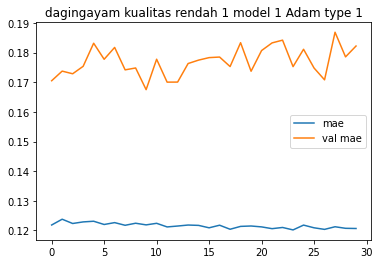

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('dagingayam kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1648.2058 4.472361 2023.358161571994


,actual,prediction
0,38200,34087.347656
1,37850,34043.675781
2,37400,34407.675781
3,37300,34554.601562
4,37150,34714.859375
...,...,...
229,35650,35468.601562
230,36250,35620.363281
231,37500,35400.101562
232,39050,35347.511719


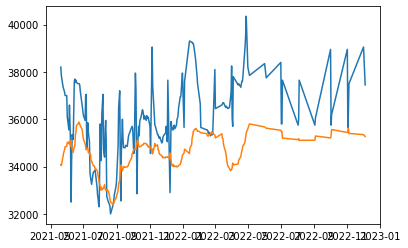

In [31]:
prediction_a2 = forecast_predict(model_a, test_dagingayam_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_dagingayam_a2 = pd.DataFrame()
# data_new_dagingayam1['date'] = date_test
data_new_dagingayam_a2['actual'] = x_test
data_new_dagingayam_a2['prediction'] = data_result_a2
data_new_dagingayam_a2.to_csv('dagingayam_model1_adam_type3.csv')

plt.plot(y_test, data_new_dagingayam_a2.actual)
plt.plot(y_test, data_new_dagingayam_a2.prediction)
data_new_dagingayam_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.1083 - mae: 0.2652 - mape: 236436.2188 - val_loss: 0.0586 - val_mae: 0.1980 - val_mape: 33.8682
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0480 - mae: 0.1729 - mape: 1568266.7500 - val_loss: 0.0727 - val_mae: 0.2230 - val_mape: 36.0502
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0451 - mae: 0.1646 - mape: 1524681.0000 - val_loss: 0.0764 - val_mae: 0.2300 - val_mape: 36.8791
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0442 - mae: 0.1649 - mape: 1554703.8750 - val_loss: 0.0890 - val_mae: 0.2535 - val_mape: 39.7969
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0441 - mae: 0.1603 - mape: 1376689.8750 - val_loss: 0.0643 - val_mae: 0.2070 - val_mape: 34.3758
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0439 - mae: 0.1619 - mape: 1574673.7500 - val_loss: 0.0710 - val_m

17/17 [==============================] - 0s 6ms/step - loss: 0.0521 - mae: 0.1865 - mape: 26.9031


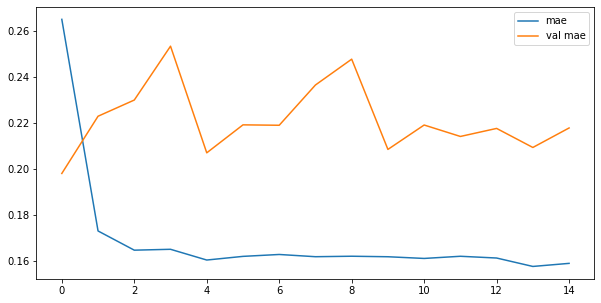

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_dagingayam_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_dagingayam1 = pd.DataFrame()
data_new_dagingayam1['actual'] = x_test
data_new_dagingayam1['prediction'] = data_result1
data_new_dagingayam1.to_csv('dagingayam_model2_adam_type1.csv')

data_new_dagingayam1

131/131 [==============================] - 2s 7ms/step
2013.391 5.4786105 2337.792120784053


,actual,prediction
0,38200,33515.605469
1,37850,33545.234375
2,37400,33619.328125
3,37300,33658.714844
4,37150,33749.117188
...,...,...
229,35650,34800.113281
230,36250,34776.523438
231,37500,34759.480469
232,39050,34748.718750


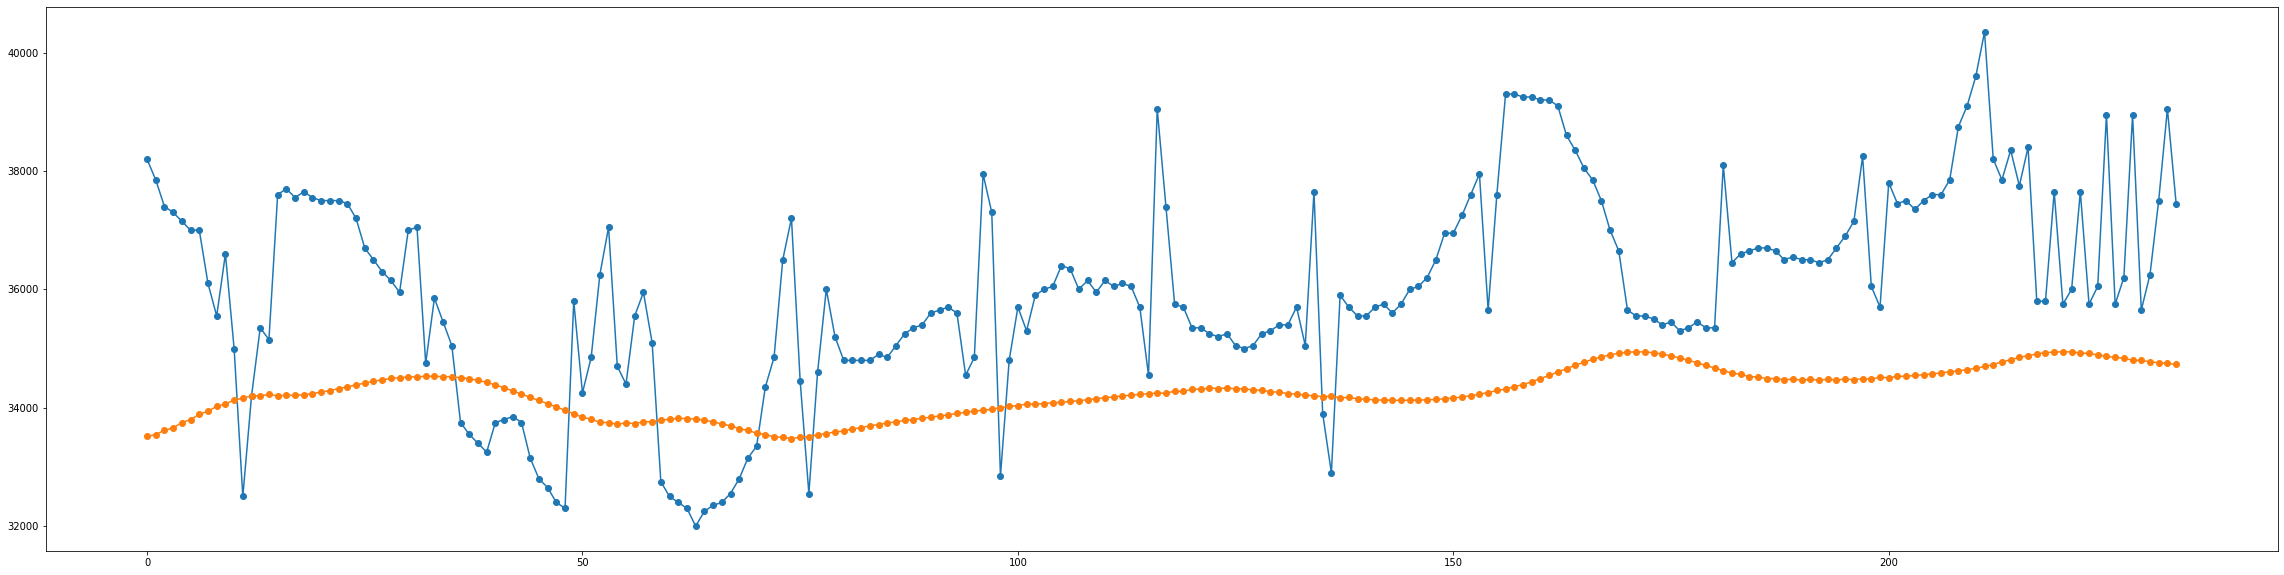

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_dagingayam1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_dagingayam1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0315 - mae: 0.1376 - mape: 454961.0625 - val_loss: 0.0579 - val_mae: 0.1918 - val_mape: 32.8462
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0302 - mae: 0.1347 - mape: 379792.4062 - val_loss: 0.0699 - val_mae: 0.2148 - val_mape: 35.0302
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0298 - mae: 0.1347 - mape: 408239.0312 - val_loss: 0.0679 - val_mae: 0.2099 - val_mape: 34.4900
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0297 - mae: 0.1337 - mape: 406501.5312 - val_loss: 0.0466 - val_mae: 0.1681 - val_mape: 32.0279
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0295 - mae: 0.1341 - mape: 376153.3438 - val_loss: 0.0696 - val_mae: 0.2134 - val_mape: 35.0714
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0292 - mae: 0.1314 - mape: 358223.7812 - val_loss: 0.0724 - val_

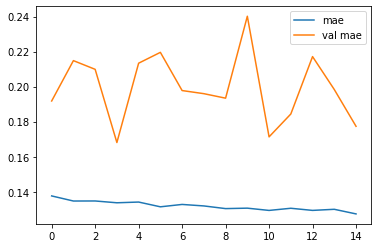

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
1638.3542 4.4572544 2337.792120784053


,actual,prediction
0,38200,33729.265625
1,37850,33823.437500
2,37400,33963.347656
3,37300,34114.660156
4,37150,34281.328125
...,...,...
229,35650,35685.441406
230,36250,35605.718750
231,37500,35524.460938
232,39050,35540.988281


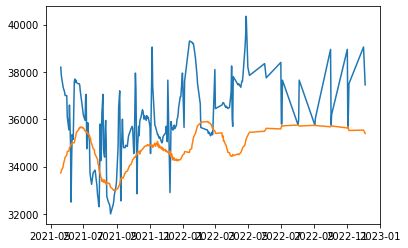

In [39]:
prediction1_1 = forecast_predict(model1, test_dagingayam_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_dagingayam1_1 = pd.DataFrame()
data_new_dagingayam1_1['actual'] = x_test
data_new_dagingayam1_1['prediction'] = data_result1_1
data_new_dagingayam1_1.to_csv('dagingayam_model2_adam_type2.csv')

plt.plot(y_test, data_new_dagingayam1_1.actual)
plt.plot(y_test, data_new_dagingayam1_1.prediction)
data_new_dagingayam1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 3s 30ms/step - loss: 0.0266 - mae: 0.1241 - mape: 544036.8125 - val_loss: 0.0538 - val_mae: 0.1840 - val_mape: 32.3299
Epoch 2/15
84/84 [==============================] - 2s 24ms/step - loss: 0.0263 - mae: 0.1232 - mape: 556477.8750 - val_loss: 0.0566 - val_mae: 0.1880 - val_mape: 32.4160
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0264 - mae: 0.1229 - mape: 516801.2188 - val_loss: 0.0548 - val_mae: 0.1854 - val_mape: 32.3640
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0264 - mae: 0.1224 - mape: 544522.6250 - val_loss: 0.0563 - val_mae: 0.1875 - val_mape: 32.4251
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0261 - mae: 0.1219 - mape: 544604.3125 - val_loss: 0.0538 - val_mae: 0.1840 - val_mape: 32.3687
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0261 - mae: 0.1219 - mape: 521637.0625 - val_loss: 0.0572 - val_mae: 0

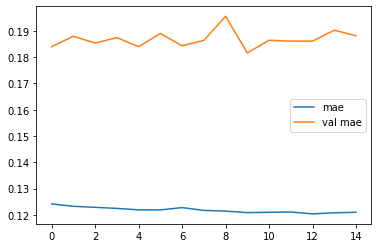

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1705.0303 4.626635 2337.792120784053


,actual,prediction
0,38200,33620.984375
1,37850,33744.773438
2,37400,33832.628906
3,37300,34040.878906
4,37150,34115.214844
...,...,...
229,35650,35637.917969
230,36250,35518.347656
231,37500,35408.777344
232,39050,35385.054688


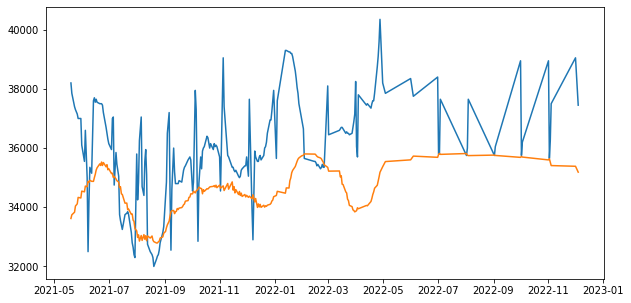

In [42]:
prediction1_2 = forecast_predict(model1, test_dagingayam_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_dagingayam1_2 = pd.DataFrame()
data_new_dagingayam1_2['actual'] = x_test
data_new_dagingayam1_2['prediction'] = data_result1_2
data_new_dagingayam1_2.to_csv('dagingayam_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_dagingayam1_2.actual)
plt.plot(y_test, data_new_dagingayam1_2.prediction)

data_new_dagingayam1_2

### SGD

In [43]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 47ms/step - loss: 0.1710 - mae: 0.3599 - mape: 6320.4990 - val_loss: 0.3516 - val_mae: 0.5595 - val_mape: 88.7879
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1256 - mae: 0.2960 - mape: 476695.5000 - val_loss: 0.2829 - val_mae: 0.4943 - val_mape: 76.5857
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0963 - mae: 0.2522 - mape: 629896.5000 - val_loss: 0.2349 - val_mae: 0.4431 - val_mape: 67.0028
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0772 - mae: 0.2192 - mape: 796658.5000 - val_loss: 0.1987 - val_mae: 0.4033 - val_mape: 60.6006
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0645 - mae: 0.1953 - mape: 1053964.3750 - val_loss: 0.1735 - val_mae: 0.3740 - val_mape: 56.3028
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0565 - mae: 0.1805 - mape: 1218448.2500 - val_loss: 0.1535 - val_mae: 0

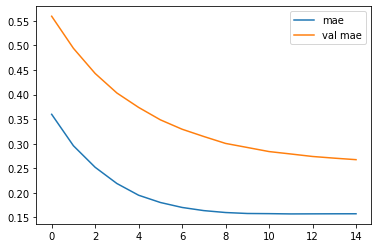

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2856.6707 7.7636175 3217.9757612511626


,actual,prediction
0,38200,33141.390625
1,37850,33122.964844
2,37400,33154.937500
3,37300,33140.328125
4,37150,33169.593750
...,...,...
229,35650,33326.710938
230,36250,33324.113281
231,37500,33323.492188
232,39050,33322.070312


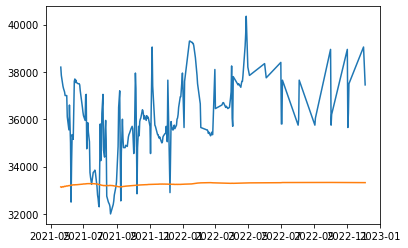

In [47]:
prediction1_a = forecast_predict(model1_a, test_dagingayam_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_dagingayam1_a = pd.DataFrame()
data_new_dagingayam1_a['actual'] = x_test
data_new_dagingayam1_a['prediction'] = data_result1_a
data_new_dagingayam1_a.to_csv('dagingayam_model2_sgd_type1.csv')


plt.plot(y_test, data_new_dagingayam1_a.actual)
plt.plot(y_test, data_new_dagingayam1_a.prediction)

data_new_dagingayam1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0344 - mae: 0.1421 - mape: 569579.5000 - val_loss: 0.0808 - val_mae: 0.2382 - val_mape: 37.7418
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0333 - mae: 0.1414 - mape: 546321.6250 - val_loss: 0.0770 - val_mae: 0.2307 - val_mape: 36.8043
Epoch 3/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0331 - mae: 0.1406 - mape: 566296.3125 - val_loss: 0.0766 - val_mae: 0.2299 - val_mape: 36.6936
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0328 - mae: 0.1410 - mape: 561735.2500 - val_loss: 0.0729 - val_mae: 0.2228 - val_mape: 35.8743
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0324 - mae: 0.1401 - mape: 566078.6250 - val_loss: 0.0736 - val_mae: 0.2236 - val_mape: 35.9261
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0323 - mae: 0.1395 - mape: 537182.8125 - val_loss: 0.0737 - val

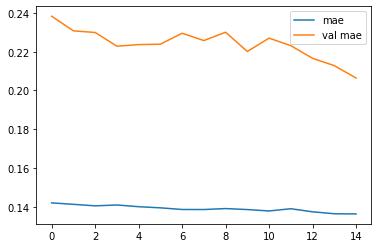

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1911.5128 5.2042 2236.643690890438


,actual,prediction
0,38200,33852.054688
1,37850,33817.648438
2,37400,33940.476562
3,37300,33926.535156
4,37150,34052.210938
...,...,...
229,35650,34824.953125
230,36250,34807.605469
231,37500,34794.984375
232,39050,34775.703125


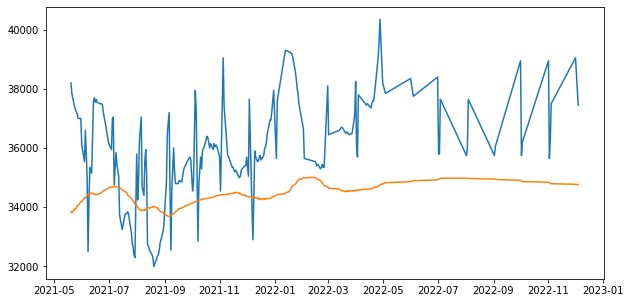

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_dagingayam_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_dagingayam1_a1 = pd.DataFrame()
data_new_dagingayam1_a1['actual'] = x_test
data_new_dagingayam1_a1['prediction'] = data_result1_a1
data_new_dagingayam1_a1.to_csv('dagingayam_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_dagingayam1_a1.actual)
plt.plot(y_test, data_new_dagingayam1_a1.prediction)
data_new_dagingayam1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0302 - mae: 0.1337 - mape: 864423.3750 - val_loss: 0.0678 - val_mae: 0.2121 - val_mape: 34.7083
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0302 - mae: 0.1335 - mape: 849131.6875 - val_loss: 0.0689 - val_mae: 0.2142 - val_mape: 34.9057
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0302 - mae: 0.1336 - mape: 846265.2500 - val_loss: 0.0688 - val_mae: 0.2140 - val_mape: 34.8883
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0302 - mae: 0.1335 - mape: 831677.3125 - val_loss: 0.0683 - val_mae: 0.2131 - val_mape: 34.7987
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0302 - mae: 0.1334 - mape: 845760.5625 - val_loss: 0.0680 - val_mae: 0.2126 - val_mape: 34.7491
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0302 - mae: 0.1336 - mape: 845508.4375 - val_loss: 0.0689 - val_mae: 0

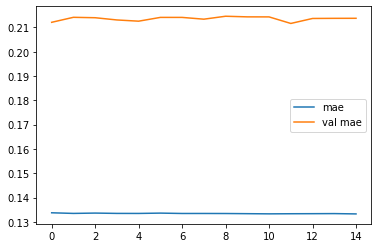

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2054.9124 5.590339 2379.326795545328


,actual,prediction
0,38200,33673.101562
1,37850,33637.511719
2,37400,33767.093750
3,37300,33751.183594
4,37150,33885.636719
...,...,...
229,35650,34607.125000
230,36250,34588.972656
231,37500,34575.472656
232,39050,34556.324219


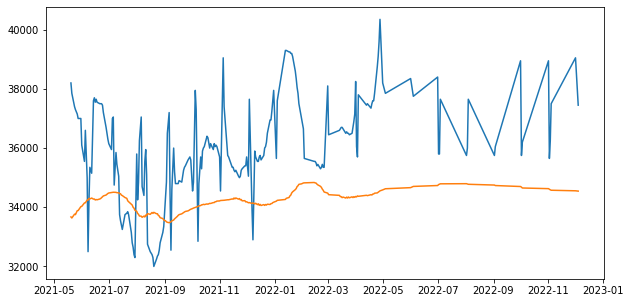

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_dagingayam_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_dagingayam1_a2 = pd.DataFrame()
data_new_dagingayam1_a2['actual'] = x_test
data_new_dagingayam1_a2['prediction'] = data_result1_a2
data_new_dagingayam1_a2.to_csv('dagingayam_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_dagingayam1_a2.actual)
plt.plot(y_test, data_new_dagingayam1_a2.prediction)

data_new_dagingayam1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.1708 - mae: 0.3587 - mape: 126705.5781 - val_loss: 0.3605 - val_mae: 0.5674 - val_mape: 90.2765
Epoch 2/50
44/44 [==============================] - 1s 15ms/step - loss: 0.1336 - mae: 0.3075 - mape: 321744.4062 - val_loss: 0.3013 - val_mae: 0.5126 - val_mape: 80.0180
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1063 - mae: 0.2686 - mape: 487399.5938 - val_loss: 0.2572 - val_mae: 0.4677 - val_mape: 71.6106
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0872 - mae: 0.2371 - mape: 790450.8125 - val_loss: 0.2229 - val_mae: 0.4294 - val_mape: 64.4547
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0736 - mae: 0.2129 - mape: 858492.6875 - val_loss: 0.1962 - val_mae: 0.4004 - val_mape: 60.1611
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0641 - mae: 0.1944 - mape: 1082609.1250 - val_loss: 0.1758 - val_mae: 

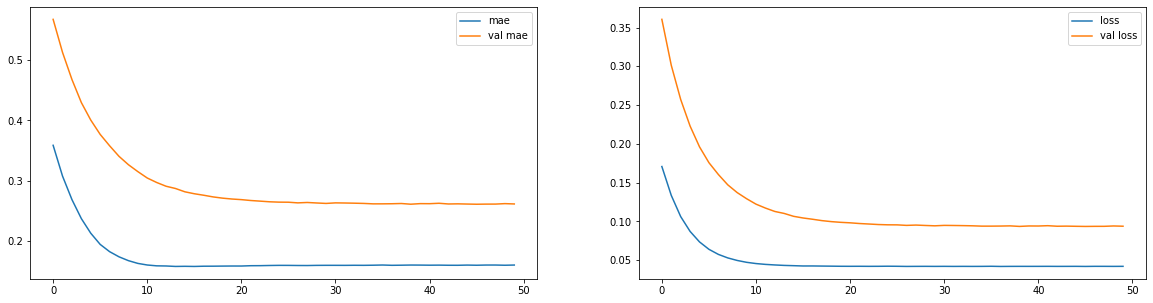

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
2791.2715 7.5855227 3151.6300544321507


,actual,prediction
0,38200,33298.363281
1,37850,33297.355469
2,37400,33305.394531
3,37300,33303.398438
4,37150,33313.093750
...,...,...
229,35650,33362.898438
230,36250,33363.863281
231,37500,33364.378906
232,39050,33364.496094


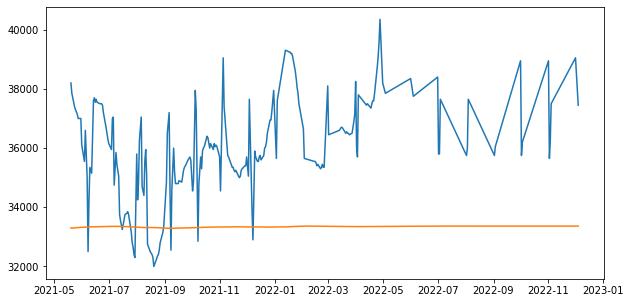

In [58]:
prediction2 = forecast_predict(model2, test_dagingayam_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_dagingayam2 = pd.DataFrame()
data_new_dagingayam2['actual'] = x_test
data_new_dagingayam2['prediction'] = data_result2
data_new_dagingayam2.to_csv('dagingayam_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_dagingayam2.actual)
plt.plot(y_test, data_new_dagingayam2.prediction)
data_new_dagingayam2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0347 - mae: 0.1436 - mape: 562448.3125 - val_loss: 0.0801 - val_mae: 0.2370 - val_mape: 37.5779
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0343 - mae: 0.1428 - mape: 560290.0000 - val_loss: 0.0786 - val_mae: 0.2341 - val_mape: 37.2331
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0339 - mae: 0.1425 - mape: 573642.0000 - val_loss: 0.0801 - val_mae: 0.2369 - val_mape: 37.5653
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0340 - mae: 0.1426 - mape: 606149.7500 - val_loss: 0.0820 - val_mae: 0.2406 - val_mape: 38.0269
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0338 - mae: 0.1427 - mape: 583468.1875 - val_loss: 0.0818 - val_mae: 0.2402 - val_mape: 37.9845
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0342 - mae: 0.1429 - mape: 580129.8125 - val_loss: 0.0779 - val_

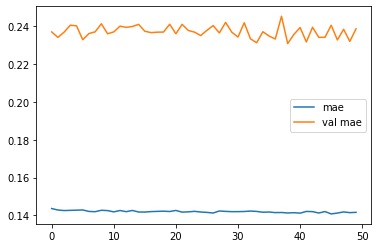

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_dagingayam_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_dagingayam2_1 = pd.DataFrame()
data_new_dagingayam2_1['actual'] = x_test
data_new_dagingayam2_1['prediction'] = data_result2_1
data_new_dagingayam2_1.to_csv('dagingayam_model3_sgd_type2.csv')

data_new_dagingayam2

199/199 [==============================] - 1s 4ms/step
2433.77 6.6151075 2776.2443156177737


,actual,prediction
0,38200,33298.363281
1,37850,33297.355469
2,37400,33305.394531
3,37300,33303.398438
4,37150,33313.093750
...,...,...
229,35650,33362.898438
230,36250,33363.863281
231,37500,33364.378906
232,39050,33364.496094


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0315 - mae: 0.1370 - mape: 929170.9375 - val_loss: 0.0799 - val_mae: 0.2367 - val_mape: 37.5486
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0315 - mae: 0.1372 - mape: 945389.0625 - val_loss: 0.0794 - val_mae: 0.2357 - val_mape: 37.4249
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0315 - mae: 0.1368 - mape: 936482.1250 - val_loss: 0.0790 - val_mae: 0.2350 - val_mape: 37.3373
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0314 - mae: 0.1370 - mape: 937604.0625 - val_loss: 0.0795 - val_mae: 0.2359 - val_mape: 37.4472
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0313 - mae: 0.1368 - mape: 915157.3750 - val_loss: 0.0789 - val_mae: 0.2348 - val_mape: 37.3086
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0314 - mae: 0.1369 - mape: 955869.3125 - val_loss: 0.0794 - val_mae: 0

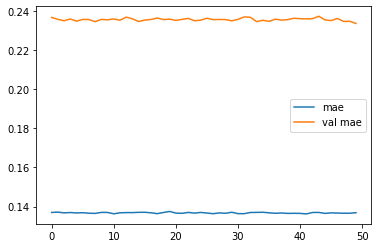

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_dagingayam_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_dagingayam2_2 = pd.DataFrame()
data_new_dagingayam2_2['actual'] = x_test
data_new_dagingayam2_2['prediction'] = data_result2_2
data_new_dagingayam2_2.to_csv('dagingayam_model3_sgd-type3.csv')

data_new_dagingayam2_2

181/181 [==============================] - 1s 4ms/step
2366.8 6.433769 2705.4220557983185


,actual,prediction
0,38200,33627.687500
1,37850,33598.957031
2,37400,33659.109375
3,37300,33655.117188
4,37150,33699.539062
...,...,...
229,35650,34034.292969
230,36250,34034.558594
231,37500,34038.046875
232,39050,34012.023438


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 35ms/step - loss: 0.1510 - mae: 0.3311 - mape: 37278.4102 - val_loss: 0.2762 - val_mae: 0.4876 - val_mape: 75.3593
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0680 - mae: 0.2012 - mape: 844719.9375 - val_loss: 0.1016 - val_mae: 0.2744 - val_mape: 42.3228
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0456 - mae: 0.1673 - mape: 1692884.5000 - val_loss: 0.1086 - val_mae: 0.2851 - val_mape: 43.6550
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0447 - mae: 0.1665 - mape: 1767131.6250 - val_loss: 0.1149 - val_mae: 0.2940 - val_mape: 44.7785
Epoch 5/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0453 - mae: 0.1660 - mape: 1613091.5000 - val_loss: 0.1221 - val_mae: 0.3047 - val_mape: 46.2350
Epoch 6/50
44/44 [==============================] - 1s 22ms/step - loss: 0.0455 - mae: 0.1659 - mape: 1677164.0000 - val_loss: 0.1081 - val_mae

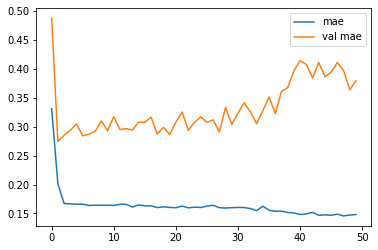

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_dagingayam_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_dagingayam2_a = pd.DataFrame()
data_new_dagingayam2_a['actual'] = x_test
data_new_dagingayam2_a['prediction'] = data_result2_a
data_new_dagingayam2_a.to_csv('dagingayam_model3_adam-type1.csv')

data_new_dagingayam2_a

131/131 [==============================] - 1s 6ms/step
2447.0833 6.6357994 2879.7806340066945


,actual,prediction
0,38200,34366.660156
1,37850,34287.019531
2,37400,34573.769531
3,37300,34679.355469
4,37150,34627.847656
...,...,...
229,35650,33231.738281
230,36250,33240.828125
231,37500,33211.667969
232,39050,33213.535156


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0314 - mae: 0.1381 - mape: 411216.6562 - val_loss: 0.0990 - val_mae: 0.2702 - val_mape: 41.7202
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0303 - mae: 0.1335 - mape: 502276.2188 - val_loss: 0.1129 - val_mae: 0.2922 - val_mape: 44.7226
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0304 - mae: 0.1354 - mape: 464719.5625 - val_loss: 0.1047 - val_mae: 0.2795 - val_mape: 43.0534
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0301 - mae: 0.1326 - mape: 427935.0312 - val_loss: 0.1004 - val_mae: 0.2721 - val_mape: 41.9823
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0298 - mae: 0.1316 - mape: 478729.4375 - val_loss: 0.1066 - val_mae: 0.2821 - val_mape: 43.2984
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0309 - mae: 0.1362 - mape: 483065.1875 - val_loss: 0.1141 - val_

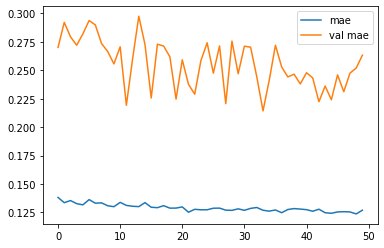

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
3013.0906 8.198055 3441.127722128314


,actual,prediction
0,38200,32261.750000
1,37850,32619.328125
2,37400,32837.214844
3,37300,32667.894531
4,37150,32746.488281
...,...,...
229,35650,33938.515625
230,36250,33891.253906
231,37500,33942.699219
232,39050,33919.617188


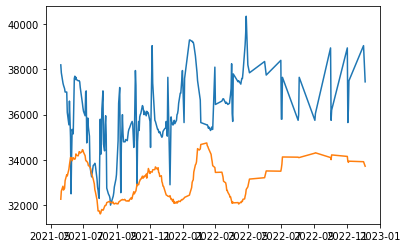

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_dagingayam_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_dagingayam2_a1 = pd.DataFrame()
data_new_dagingayam2_a1['actual'] = x_test
data_new_dagingayam2_a1['prediction'] = data_result2_a1
data_new_dagingayam2_a1.to_csv('dagingayam_model3_adam-type2.csv')

plt.plot(y_test, data_new_dagingayam2_a1.actual)
plt.plot(y_test, data_new_dagingayam2_a1.prediction)
data_new_dagingayam2_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0317 - mae: 0.1291 - mape: 842439.5625 - val_loss: 0.0795 - val_mae: 0.2366 - val_mape: 37.7922
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0277 - mae: 0.1227 - mape: 752087.6250 - val_loss: 0.0870 - val_mae: 0.2498 - val_mape: 39.3021
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0274 - mae: 0.1206 - mape: 601670.3125 - val_loss: 0.0827 - val_mae: 0.2419 - val_mape: 38.2466
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0271 - mae: 0.1211 - mape: 710464.3750 - val_loss: 0.0792 - val_mae: 0.2352 - val_mape: 37.3775
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0272 - mae: 0.1204 - mape: 677056.7500 - val_loss: 0.0784 - val_mae: 0.2334 - val_mape: 37.1284
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0272 - mae: 0.1213 - mape: 705176.1250 - val_loss: 0.0812 - val_mae: 0

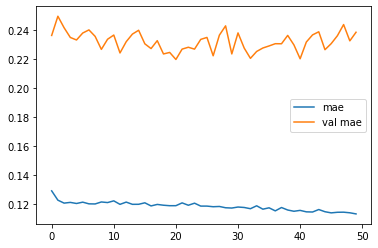

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
2078.2905 5.6329856 2601.7389377106997


,actual,prediction
0,38200,34699.335938
1,37850,34745.343750
2,37400,34983.906250
3,37300,35582.281250
4,37150,35747.476562
...,...,...
229,35650,34270.390625
230,36250,34522.871094
231,37500,34224.500000
232,39050,34084.921875


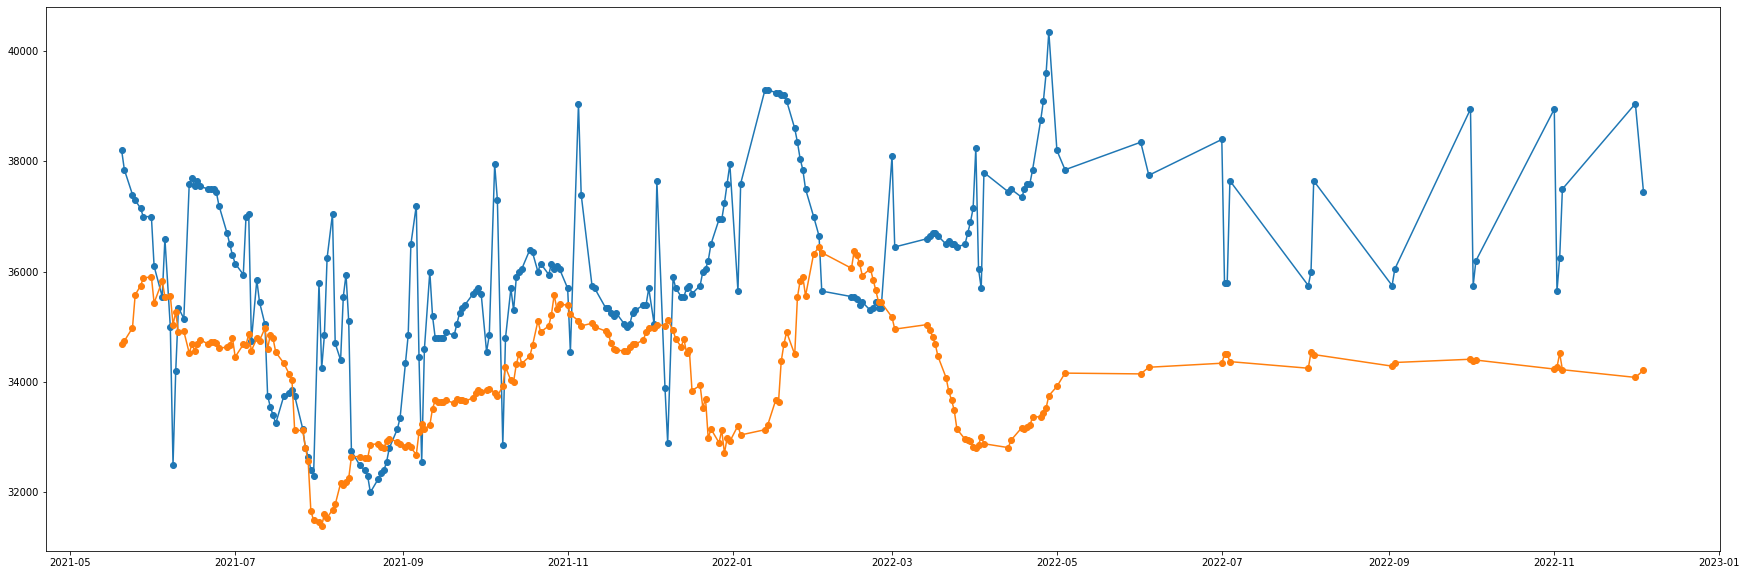

In [74]:
prediction2_a2 = forecast_predict(model2_a, test_dagingayam_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_dagingayam2_a2 = pd.DataFrame()
data_new_dagingayam2_a2['actual'] = x_test
data_new_dagingayam2_a2['prediction'] = data_result2_a2
data_new_dagingayam2_a2.to_csv('dagingayam_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_dagingayam2_a2.actual, '-o')
plt.plot(y_test,data_new_dagingayam2_a2.prediction, '-o')
data_new_dagingayam2_a2